# Implement a Siamese Network

> In this post, it will go through creating and training a multi-input model. You will build a basic Siamese Network to find the similarity or dissimilarity between items of clothing. This is the summary of lecture "Custom Models, Layers and Loss functions with Tensorflow" from DeepLearning.AI.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow, DeepLearining.AI]
- image: 

## Packages

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import random

## Prepare the Dataset

First define a few utilities for preparing and visualizing your dataset.

In [5]:
def create_pairs(x, digit_indices):
    '''
    Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)

def create_pairs_on_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    return pairs, y

def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

You can now download and prepare our train and test sets. You will also create pairs of images that will go into the multi-input model.

In [6]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
train_pairs, train_y = create_pairs_on_set(train_images, train_labels)
test_pairs, test_y = create_pairs_on_set(test_images, test_labels)

You can see a sample pair of images below.

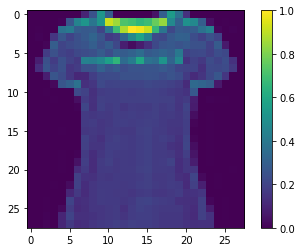

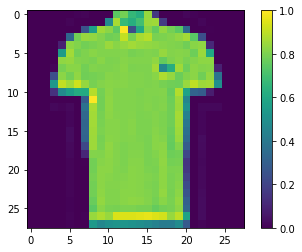

In [9]:
# array index
this_pair = 8

# show images at this index
show_image(test_pairs[this_pair][0])
show_image(test_pairs[this_pair][1])

In [10]:
test_y[this_pair]

1.0

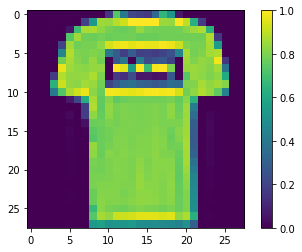

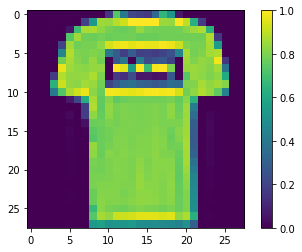

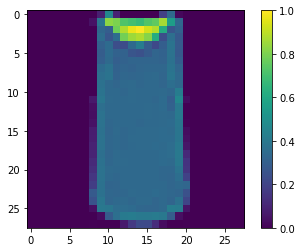

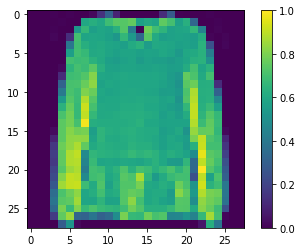

In [12]:
# print other pairs

show_image(train_pairs[:,0][0])
show_image(train_pairs[:,0][1])

show_image(train_pairs[:,1][0])
show_image(train_pairs[:,1][1])

## Build the Model

Next, you'll define some utilities for building our model.

In [15]:
def initialize_base_network():
    input = Input(shape=(28, 28,), name='base_input')
    x = Flatten(name='flatten_input')(input)
    x = Dense(128, activation='relu', name='first_base_dense')(x)
    x = Dropout(0.1, name='first_dropout')(x)
    x = Dense(128, activation='relu', name='second_base_dense')(x)
    x = Dropout(0.1, name='second_dropout')(x)
    x = Dense(128, activation='relu', name='third_base_dense')(x)
    
    return Model(inputs=input, outputs=x)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

Let's see how our base network looks. This is where the two inputs will pass through to generate an output vector.

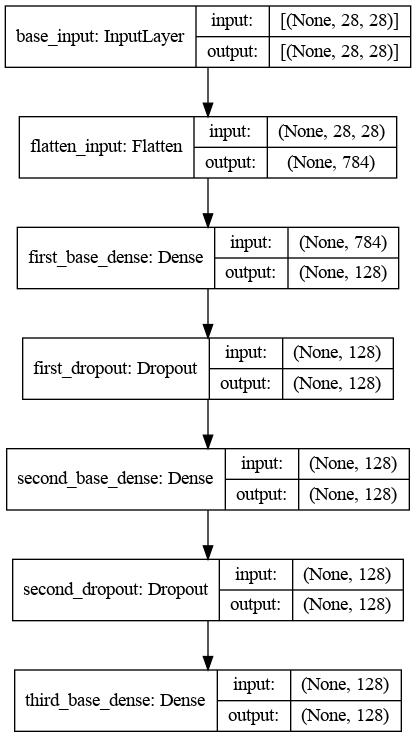

In [16]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='./siamese_network_base.png')

Let's now build the Siamese network. The plot will show two inputs going to the base network.

In [18]:
# create the left input and point to the base network
input_a = Input(shape=(28, 28,), name='left_input')
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28, 28,), name='right_input')
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name='output_layer', output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and outputs of the model
model = Model(inputs=[input_a, input_b], outputs=output)

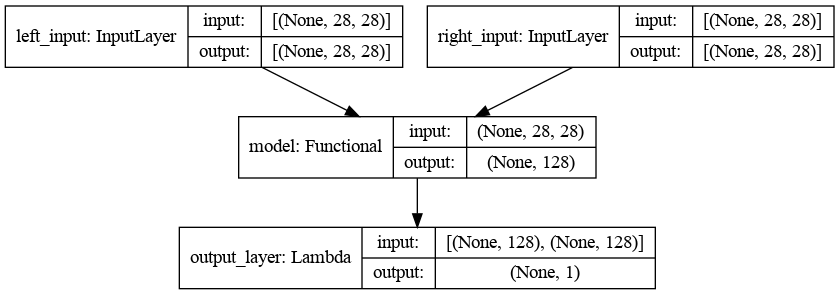

In [19]:
# plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='./siamese_network.png')

## Train the Model

You can now define the custom loss for our network and start training.

In [20]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''
        Contrastive loss from Hadsell et al, '06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [21]:
model.compile(optimizer=RMSprop(),
              loss=contrastive_loss_with_margin(margin=1))

In [22]:
history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y, epochs=20, batch_size=128, validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_y))

Epoch 1/20
938/938 [==============================] - 3s 2ms/step - loss: 0.1504 - val_loss: 0.0825
Epoch 2/20
938/938 [==============================] - 1s 2ms/step - loss: 0.0839 - val_loss: 0.0749
Epoch 3/20
938/938 [==============================] - 1s 2ms/step - loss: 0.0731 - val_loss: 0.0707
Epoch 4/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0678 - val_loss: 0.0677
Epoch 5/20
938/938 [==============================] - 1s 2ms/step - loss: 0.0637 - val_loss: 0.0696
Epoch 6/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0615 - val_loss: 0.0669
Epoch 7/20
938/938 [==============================] - 1s 2ms/step - loss: 0.0593 - val_loss: 0.0666
Epoch 8/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0594 - val_loss: 0.0657
Epoch 9/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0573 - val_loss: 0.0652
Epoch 10/20
938/938 [==============================] - 1s 2ms/step - loss: 0.0563 - val_loss: 0.0661

## Model Evaluation

As usual, you can evaluate our model by computing the accuracy and observing the metrics during training.

In [23]:
def compute_accuracy(y_true, y_pred):
    '''
    compute classification accuracy with a fixed threshold on distances
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [24]:
loss = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_y)

625/625 [==============================] - 0s 662us/step - loss: 0.0661


In [25]:
y_pred_train = model.predict([train_pairs[:, 0], train_pairs[:, 1]])
train_accuracy = compute_accuracy(train_y, y_pred_train)

y_pred_test = model.predict([test_pairs[:, 0], test_pairs[:, 1]])
test_accuracy = compute_accuracy(test_y, y_pred_test)

In [26]:
print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

Loss = 0.06613888591527939, Train Accuracy = 0.9317302883813969 Test Accuracy = 0.9106606606606606


In [30]:
def plot_metrics(history, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label=metric_name)
    plt.legend()

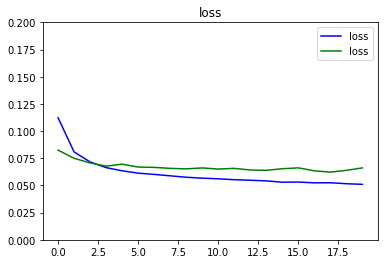

In [31]:
plot_metrics(history, metric_name='loss', title='loss', ylim=0.2)

In [32]:
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

You can see sample results for 10 pairs of items below.

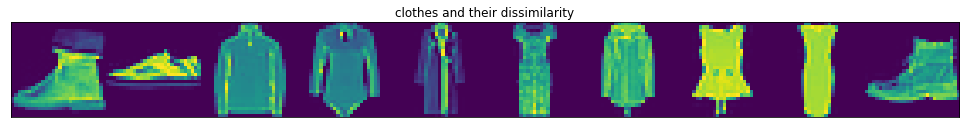

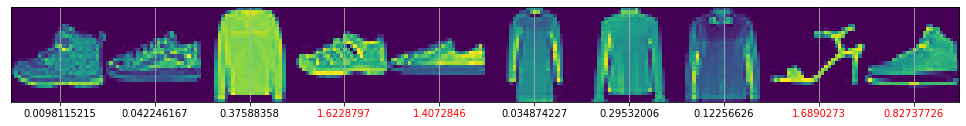

In [34]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(train_pairs[:, 0][indexes], train_pairs[:, 1][indexes], y_pred_train[indexes], train_y[indexes], "clothes and their dissimilarity", 10)